# classify the Size_Categorie using SVM


# About the attributes of the data

 # month	month of the year: 'jan' to 'dec'
 # day	day of the week: 'mon' to 'sun'
 # FFMC	FFMC index from the FWI system: 18.7 to 96.20
 # DMC	DMC index from the FWI system: 1.1 to 291.3
#  DC	DC index from the FWI system: 7.9 to 860.6
 # ISI	ISI index from the FWI system: 0.0 to 56.10
# temp	temperature in Celsius degrees: 2.2 to 33.30
# RH	relative humidity in %: 15.0 to 100
 # wind	wind speed in km/h: 0.40 to 9.40
# rain	outside rain in mm/m2 : 0.0 to 6.4
# Size_Categorie 	the burned area of the forest ( Small , Large)

In [1]:
# Importing the required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold , GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve, roc_auc_score
from sklearn.metrics import recall_score , precision_score, f1_score

In [2]:
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

In [3]:
# Load the data set ' forestfires.csv'
df = pd.read_csv('forestfires.csv')
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


# # Labeling rows has been droped for reducing the dimensions for time being. we will do the label encoding later

In [4]:
df.drop(df.columns[11:30],axis = 1,inplace = True)

In [5]:
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,small


# Basic EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [7]:
df['size_category'].value_counts()

small    378
large    139
Name: size_category, dtype: int64

In [8]:
df[df.duplicated()]

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
53,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00,small
100,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00,small
215,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66,large
303,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00,small
426,aug,thu,91.6,248.4,753.8,6.3,20.4,56,2.2,0.0,0.00,small
461,aug,sat,93.7,231.1,715.1,8.4,18.9,64,4.9,0.0,0.00,small
501,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,small
508,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,small


In [9]:
df.drop_duplicates(inplace = True)

In [10]:
df.shape

(509, 12)

# # From the above we have dropped duplicates and no null values are there in the data frame

In [12]:
# Statistical analysis of the data
df.describe().round(2)

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,509.00,509.00,509.00,509.00,509.00,509.00,509.00,509.00,509.00
mean,90.62,110.24,547.79,9.02,18.87,44.25,4.01,0.02,12.99
std,5.56,63.80,248.20,4.59,5.84,16.37,1.80,0.30,64.13
min,18.70,1.10,7.90,0.00,2.20,15.00,0.40,0.00,0.00
25%,90.20,62.30,437.70,6.40,15.40,32.00,2.70,0.00,0.00
50%,91.60,108.30,664.20,8.40,19.30,42.00,4.00,0.00,0.61
75%,92.90,141.30,713.90,11.00,22.80,53.00,4.90,0.00,6.58
max,96.20,291.30,860.60,56.10,33.30,100.00,9.40,6.40,1090.84


# Visualization of the data

In [14]:
numeric_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

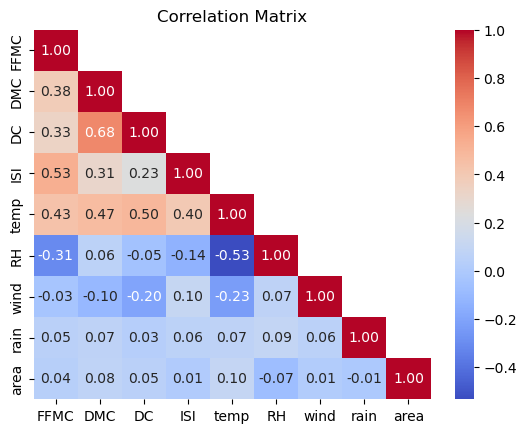

In [15]:
# Heatmap for correlation matrix
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",mask = np.triu(correlation_matrix,1))
plt.title('Correlation Matrix')
plt.show();

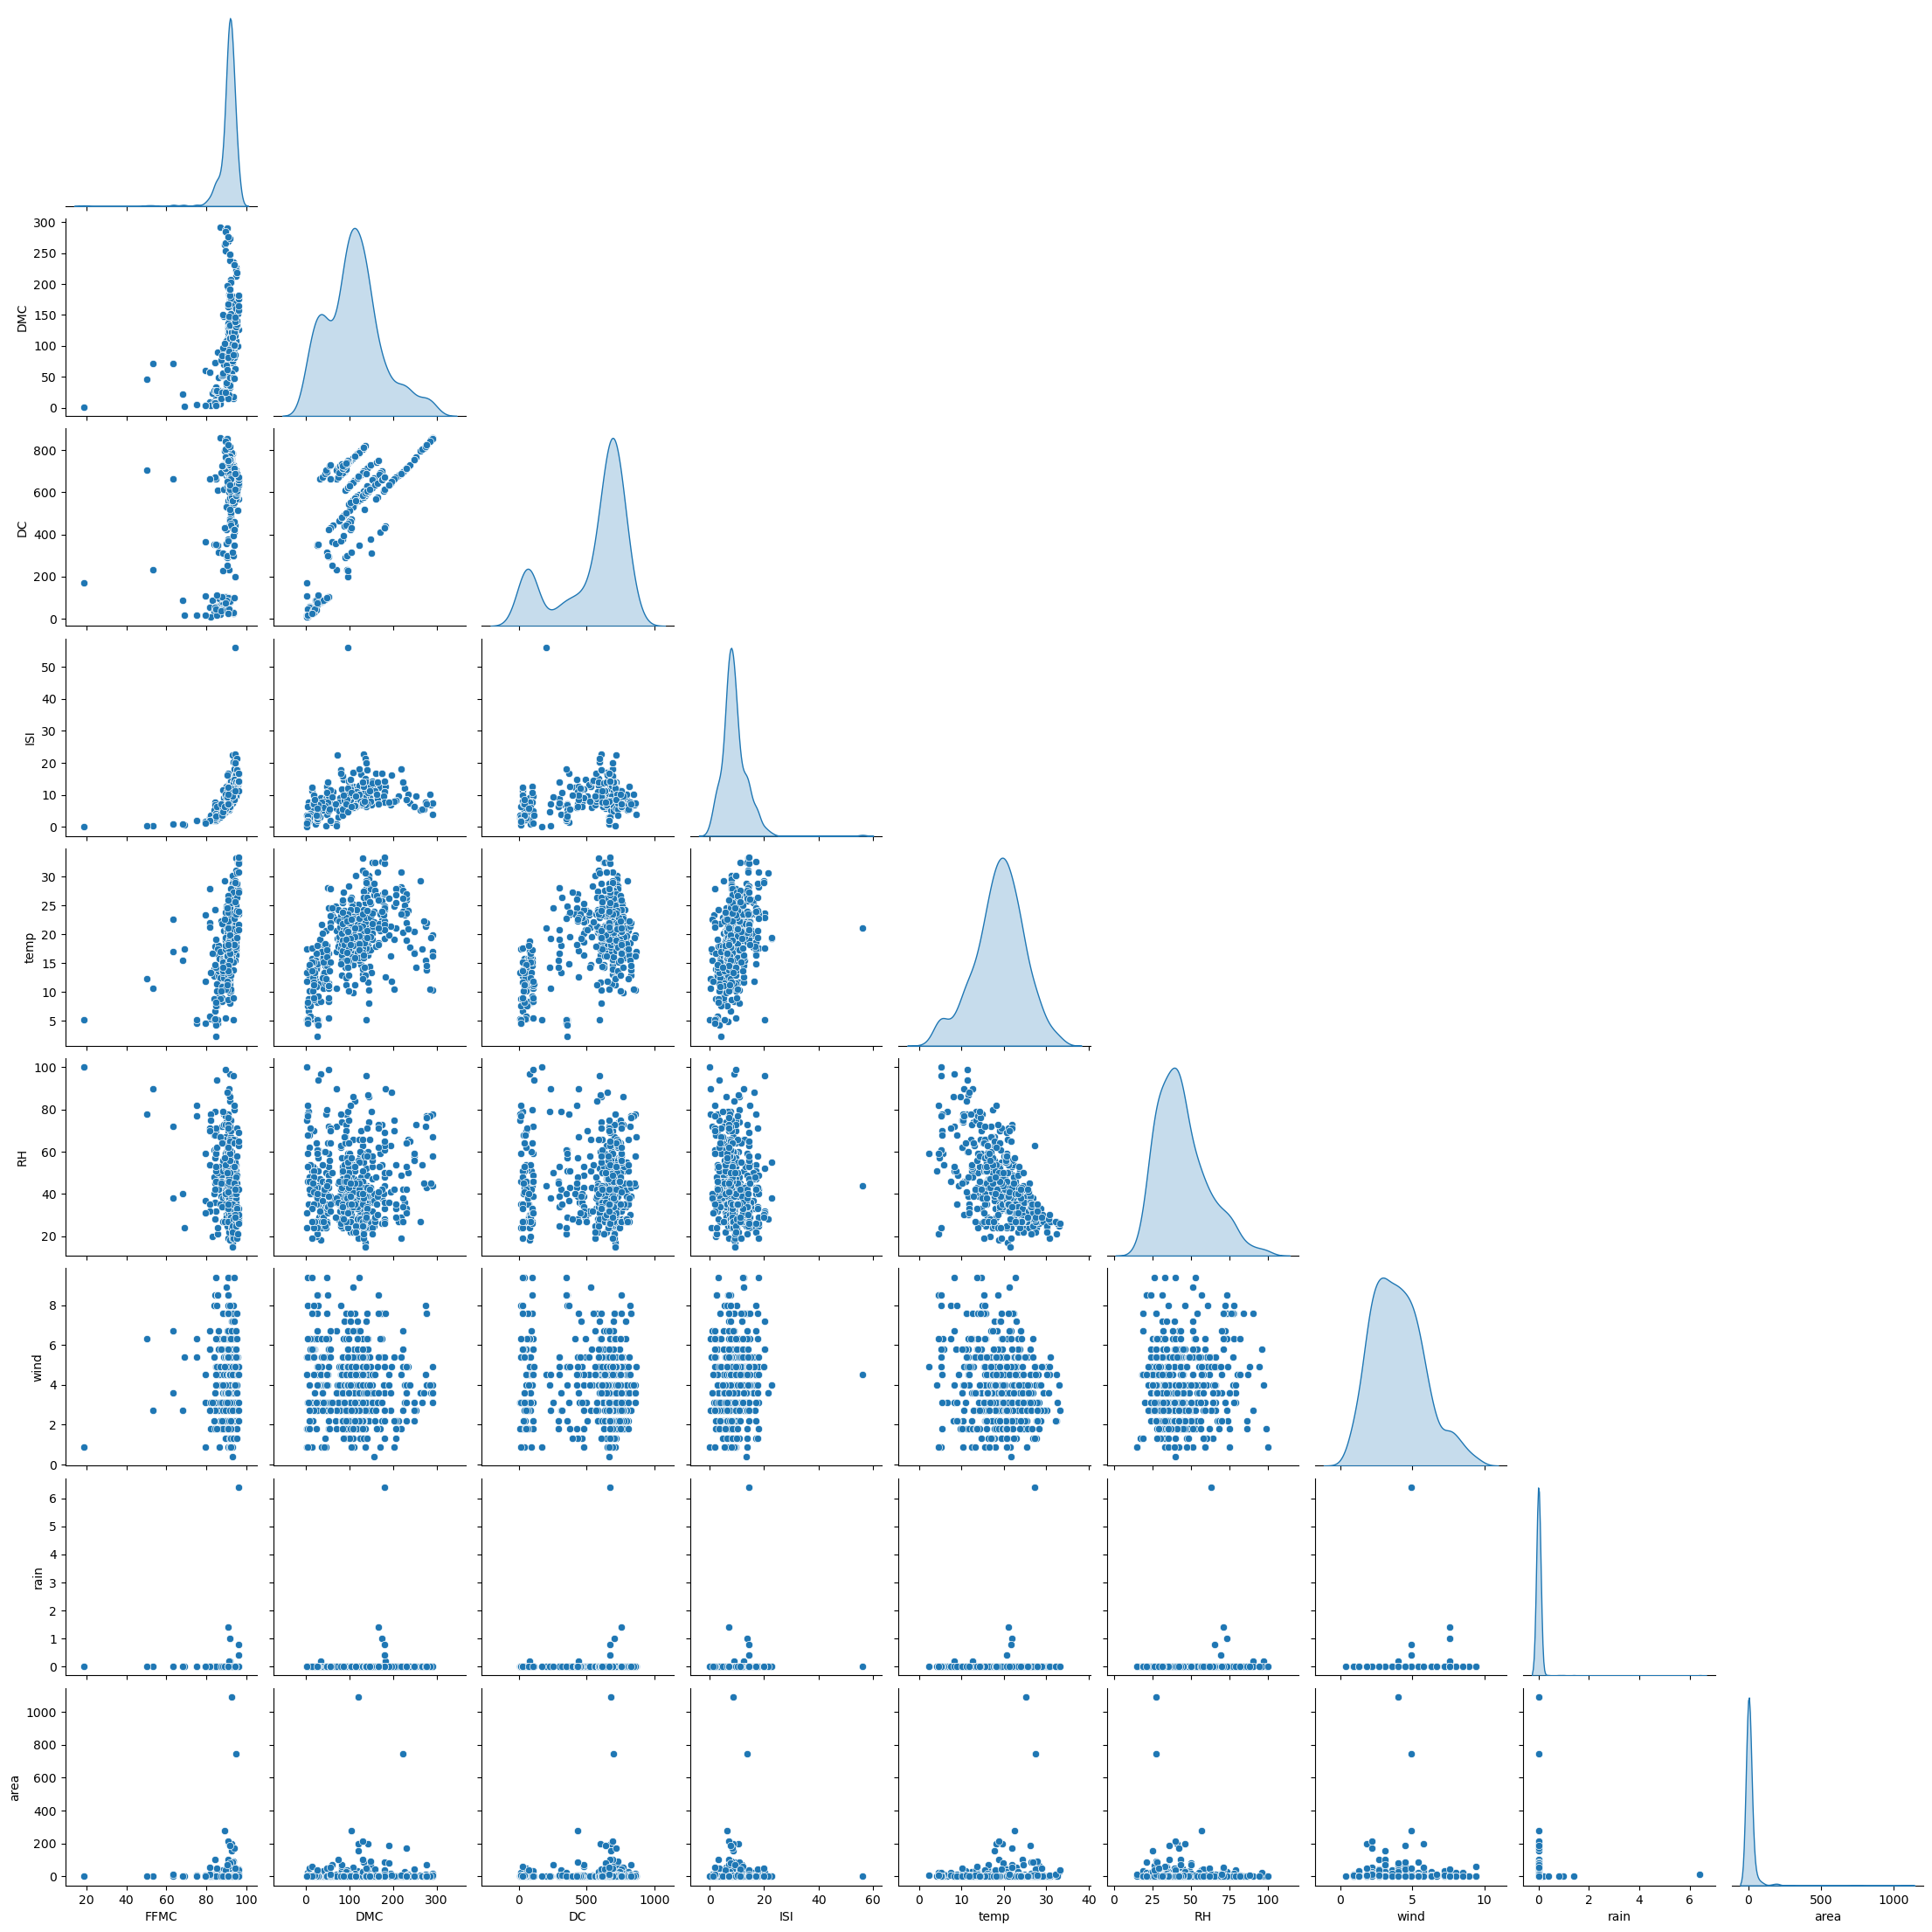

In [16]:
# Pairplot for numeric features
sns.pairplot(df[numeric_features],diag_kind = 'kde', corner = True)
plt.show();

# # There is no strong positive or negative correlaion between the features

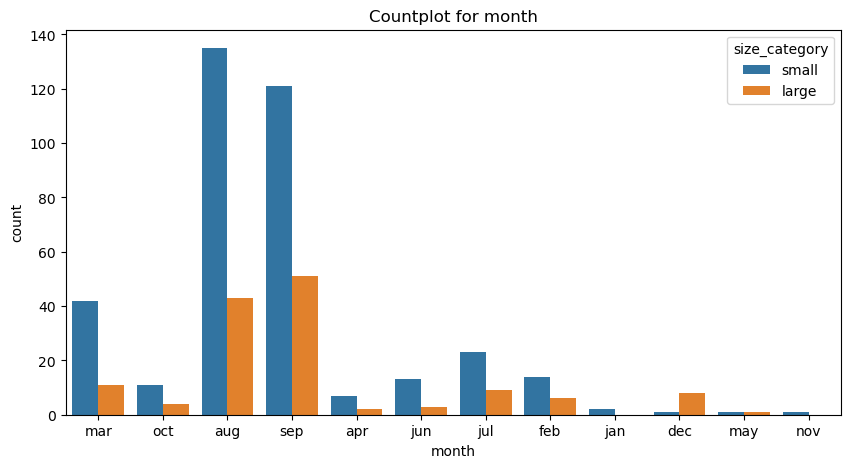

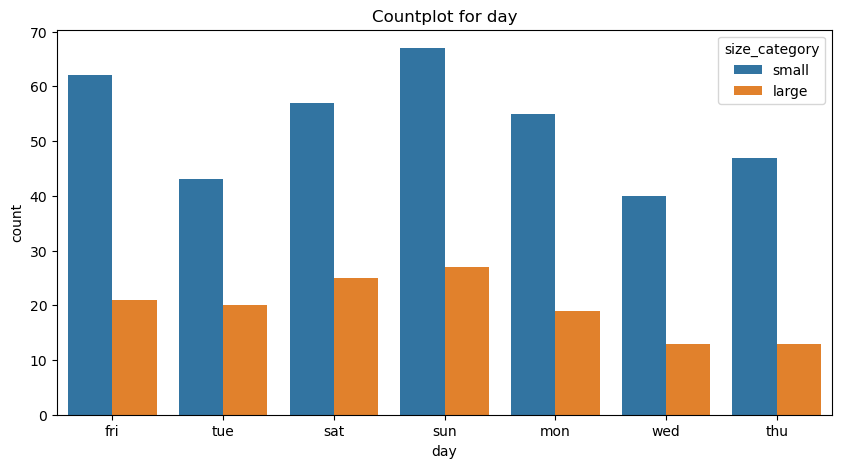

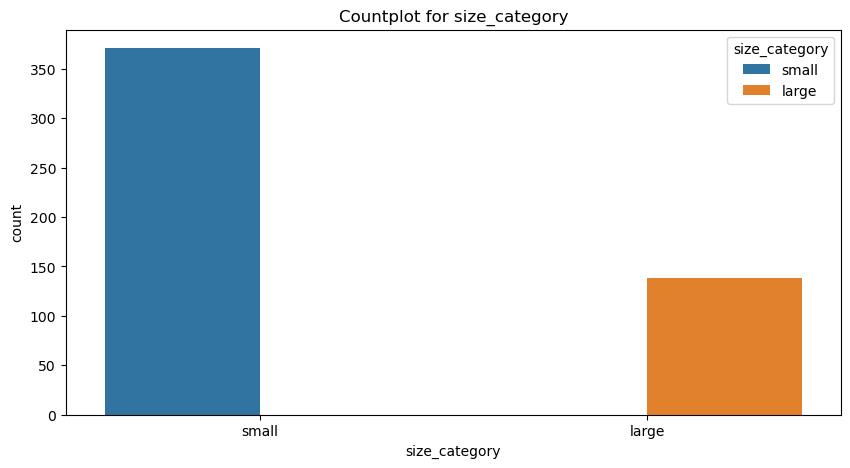

In [17]:
# Visualizing categorical features
categorical_features = ['month', 'day', 'size_category']

# Countplot for categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=feature, data=df, hue='size_category')
    plt.title(f'Countplot for {feature}')
    plt.show()

# # From the above plots , we can say that the fire happening is more in the month of august and september and in the weeknds i.e on saturdays and sundays also the fire happing is more

# Outliers Detection

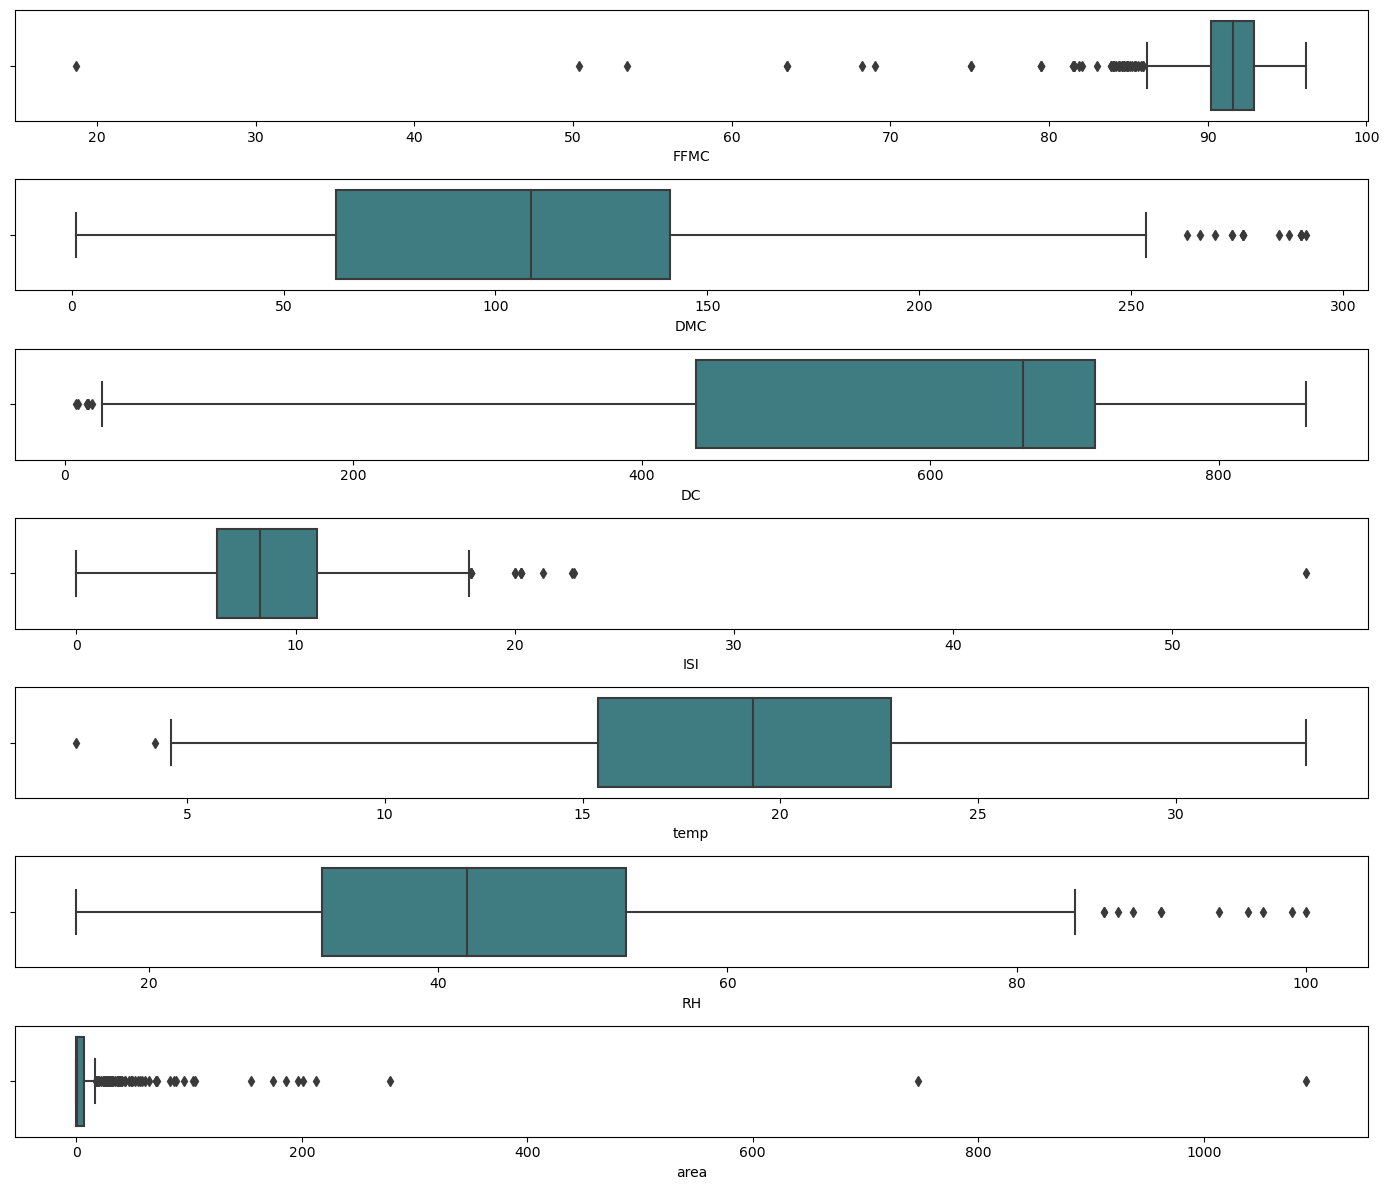

In [18]:
# Box plot for finding outliers
ot=df 
fig, axes=plt.subplots(7,1,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='FFMC',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='DMC',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='DC',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='ISI',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='temp',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='RH',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='area',data=ot,palette='crest',ax=axes[6])
plt.tight_layout();

# There are lot of outliers are there . But we can not drop them as they are present in a very large scale and they are important for model building

In [19]:
# Pie chart for 'size_category'
size_category_counts = df['size_category'].value_counts()
labels = size_category_counts.index
sizes = size_category_counts.values

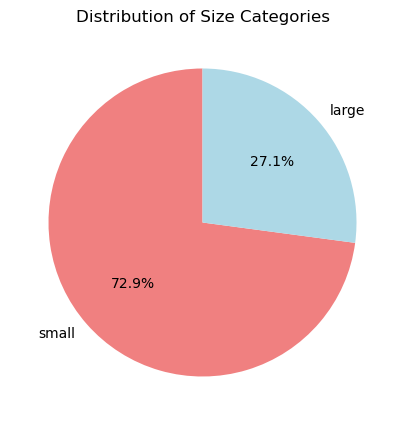

In [20]:
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
plt.title('Distribution of Size Categories')
plt.show()

# From the above pie chart, The fire covered in the small area is more when compared to large area.Means the fire covered accounted for small area is more when compared to large area

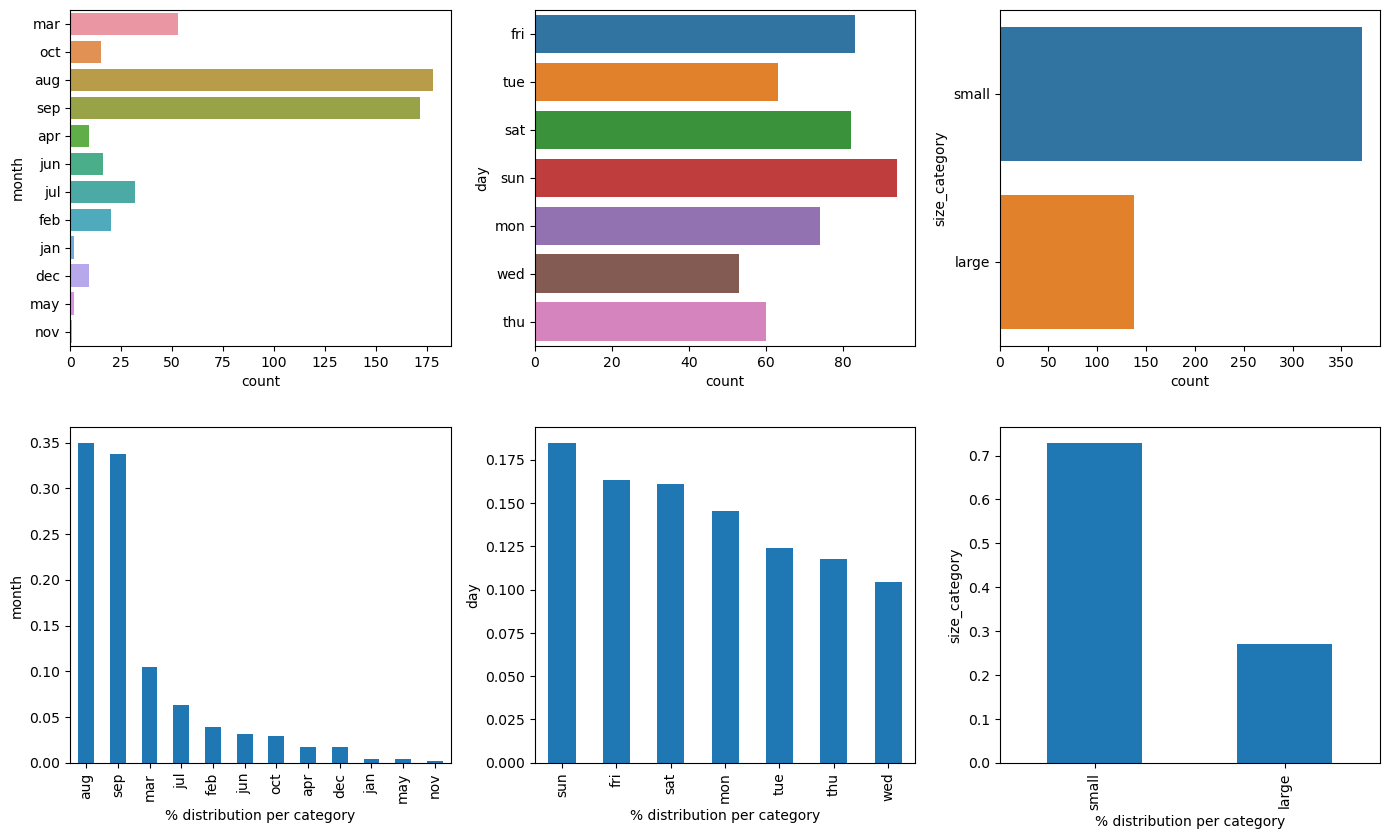

In [21]:
# analyzing categorical columns
plt.figure(figsize=(14,12))
for i,col in enumerate(categorical_features,1):
    plt.subplot(3,3,i)
    sns.countplot(df,y=col)
    plt.subplot(3,3,i+3)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

# It is interesting to see that abnormally high number of the forest fires occur in the month of August and September.

# In the case of day, the days from Friday to Monday have higher equal proportion of cases. 

# Preprocessing of the data

In [22]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['month', 'day'], drop_first=True)

In [23]:
# Converting string value into binary classes such as if "large" then classify it as '1' else 'O'
df['size_category'] = df.size_category
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,...,0,0,1,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,...,0,0,1,0,0,1,0,0,0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [25]:
df['size_category'].value_counts()

0    371
1    138
Name: size_category, dtype: int64

In [26]:
# Separate continuous and categorical features
continuous_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
categorical_features = [col for col in df.columns if col not in continuous_features]

In [28]:
# Scale only the continuous features
from sklearn.preprocessing import StandardScaler
scaler_continuous = StandardScaler()
df[continuous_features] = scaler_continuous.fit_transform(df[continuous_features])

In [29]:
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,-0.796040,-1.318386,-1.828931,-0.856568,-1.827729,0.412656,1.494370,-0.069035,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.003257,-1.174053,0.489257,-0.507267,-0.148307,-0.688321,-1.729364,-0.069035,0.0,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.003257,-1.043839,0.561045,-0.507267,-0.730964,-0.688321,-1.507037,-0.069035,0.0,0,...,0,0,1,0,0,1,0,0,0,0
3,0.194939,-1.206998,-1.896686,-0.005147,-1.810592,3.226265,-0.006333,0.606709,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.237488,-0.924607,-1.797070,0.125841,-1.279346,3.348596,-1.229129,-0.069035,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [30]:
# Split the data into train and test data
x = df.drop('size_category',axis=1)
y = df['size_category']

In [31]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1,stratify=y)

In [32]:
# Instantiate a SVM object and run with default parameters
svcl = SVC()
svcl.fit(x_train,y_train)

SVC()

In [33]:
pred_train = svcl.predict(x_train)

In [35]:
pred_train[:5]

array([1, 0, 0, 0, 0])

In [36]:
pred_test = svcl.predict(x_test)

In [38]:
pred_test[:5]

array([0, 0, 1, 1, 0])

In [39]:
acc_train = accuracy_score(y_train,pred_train)
acc_train

0.9044943820224719

In [40]:
acc_test = accuracy_score(y_test,pred_test)
acc_test

0.934640522875817

In [41]:
# print the classification report for train and test data performance
from sklearn.metrics import classification_report

In [42]:
# print the classification report of train data
print(classification_report(y_train,pred_train))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       259
           1       1.00      0.65      0.79        97

    accuracy                           0.90       356
   macro avg       0.94      0.82      0.86       356
weighted avg       0.92      0.90      0.90       356



In [44]:
# print the classification report of test data
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       112
           1       1.00      0.76      0.86        41

    accuracy                           0.93       153
   macro avg       0.96      0.88      0.91       153
weighted avg       0.94      0.93      0.93       153



# For class 0, the model has high precision, recall, and F1-score, indicating good performance.
# For class 1, the precision is perfect (1.00), but the recall is lower (0.65), which suggests that the model may be missing some instances of class 1.
# This suggests the model is performing beter on majority class well.This can be due to class imbalance.

# SMOTE Oversampling technique

In [45]:
x = df.drop(['size_category'], axis=1)
y = df['size_category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [47]:
from collections import Counter
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 259, 1: 97})
After Counter({0: 259, 1: 259})


In [49]:
x_train,x_test,y_train,y_test = train_test_split(x_train_sm,y_train_sm,
                                                 test_size=0.3,random_state=1, stratify=y_train_sm)

counter = Counter(y_train_sm)
print('Before',counter)
counter = Counter(y_train)
print('After',counter)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Before Counter({0: 259, 1: 259})
After Counter({0: 181, 1: 181})
Shape of X_train:  (362, 26)
Shape of X_test:  (156, 26)
Shape of y_train:  (362,)
Shape of y_test (156,)


In [50]:
# initiating the model with kernel tric
model = SVC(kernel='linear', probability=True)

# fit the model
model.fit(x_train, y_train)

SVC(kernel='linear', probability=True)

In [51]:
pred_train_model = model.predict(x_train)

print('SVC Model using Linear Kernel accuracy score: {0:0.4f}'. format(accuracy_score(y_train, pred_train_model)))

SVC Model using Linear Kernel accuracy score: 1.0000


In [52]:
# print the classification report

print('SVM Linear Kernel Model','\n',classification_report(y_train, pred_train_model))

SVM Linear Kernel Model 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00       181

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362



In [53]:
pred_test_model = model.predict(x_test)

print('SVC Model using Linear Kernel accuracy score on test : {0:0.3f}'. format(accuracy_score(y_test, pred_test_model)))

SVC Model using Linear Kernel accuracy score on test : 0.994


In [54]:
# print the classification report

print('SVM Linear Kernel Model on test','\n',classification_report(y_test, pred_test_model))

SVM Linear Kernel Model on test 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        78
           1       1.00      0.99      0.99        78

    accuracy                           0.99       156
   macro avg       0.99      0.99      0.99       156
weighted avg       0.99      0.99      0.99       156



# After over sampling the data and using kernel tric, the model performance is good .
# The model is giving almost 100% accuracy on train and test data

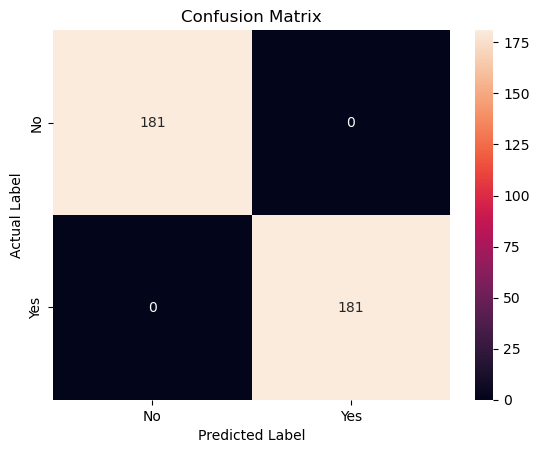

In [56]:
# plot confusion matrix to describe the performance of classifier of train data

cm_df=confusion_matrix(y_train, pred_train_model)
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm_df, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

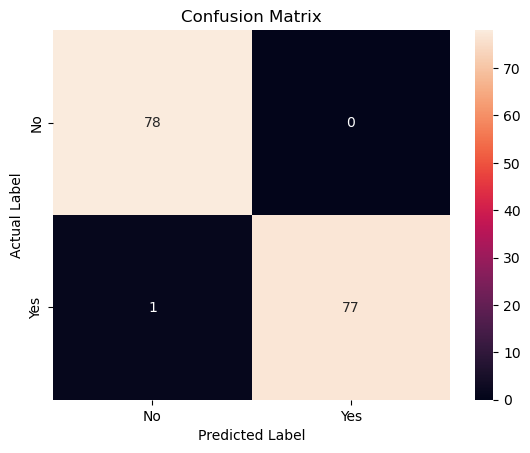

In [57]:
# plot confusion matrix to describe the performance of classifier of test data

cm_df=confusion_matrix(y_test, pred_test_model)
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm_df, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# ROC CURVE

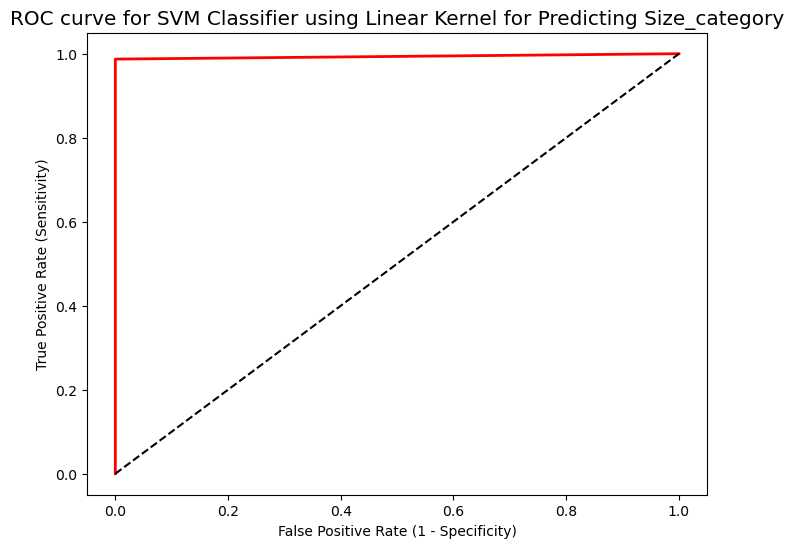

ROC AUC : 0.9936


In [58]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test_model)

plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, linewidth=2, color='red')

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for SVM Classifier using Linear Kernel for Predicting Size_category')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC_AUC = roc_auc_score(y_test, pred_test_model)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

# The model performance is almost 100% accurate